In [1]:
import os
# Change working directory
PROJECT_ROOT_DIR = "latent-communication"

current_dir = os.getcwd()

# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")
os.chdir(current_dir)
print("Currend working directory is:", os.getcwd())
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from utils.dataloaders.full_dataloaders import DataLoaderFashionMNIST
from models.definitions.vae import VAE
import numpy as np

from utils.model import get_transformations, load_model
from utils.dataloaders.get_dataloaders import define_dataloader
from utils.get_mapping import load_mapping

Currend working directory is: /mnt/c/Users/Hillary Hauger/Documents/Studium/SoSe2024/Case Study Non Linear Optimization/Code/latent-communication


A1:
[[-1.32358447e-01 -7.67239690e-01 -3.19968611e-01  5.04069388e-01
  -7.44612753e-01  7.42603019e-02  5.63326538e-01 -1.67053550e-01
   3.99838649e-02  1.50538869e-02]
 [ 1.42130017e+00 -1.80441117e+00  2.82120085e+00  2.47901392e+00
  -5.99303305e-01  1.87369883e+00  1.49100006e+00 -2.36853552e+00
   4.32691932e-01  1.26581311e+00]
 [-1.44877166e-01 -1.14116180e+00  9.68463361e-01 -7.96759665e-01
   1.76394582e-01  1.07321131e+00  5.47238708e-01 -1.12304974e+00
   8.07125211e-01  2.93370843e-01]
 [-5.47137201e-01 -6.69668466e-02  3.57426256e-01  4.20507401e-01
   2.64527112e-01  3.61503839e-01 -2.07596477e-02 -6.18031979e-01
   1.41372442e-01  6.68147922e-01]
 [ 8.31350625e-01  1.41325116e-01  5.73533140e-02  3.85980874e-01
  -2.75099248e-01  2.89613277e-01 -4.16284293e-01  2.40581646e-03
  -7.39469051e-01  5.99138081e-01]
 [-8.05739462e-02 -7.01431394e-01 -1.81834862e-01  4.90928769e-01
  -1.67260602e-01 -3.35473865e-01  4.72459972e-01  1.69981337e+00
  -4.14067626e-01 -1.14002995

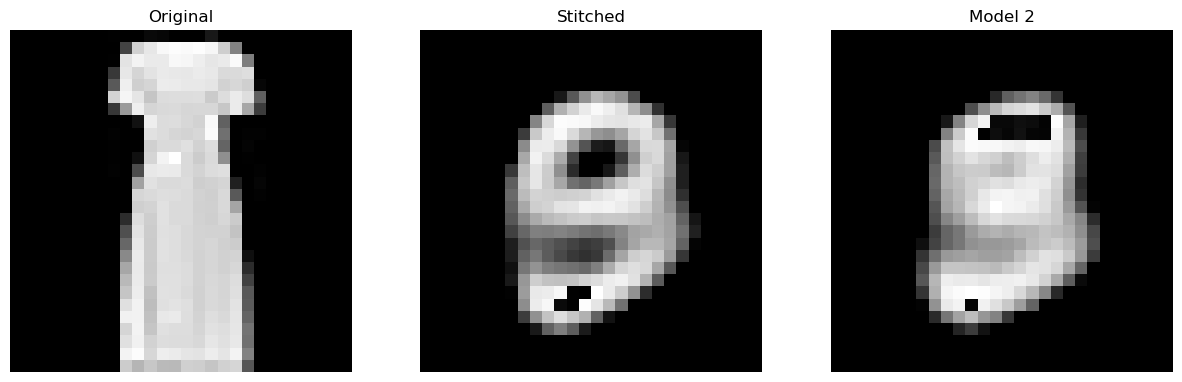

In [3]:
# File path to the model
mapping_path = "results/transformations/mapping_files/PCKTAE/"
mapping_type = "Decouple"
num_samples = 10
lamda = 0.5
sampling_strategy = "convex_hull"
mapping_name = f'FMNIST_PCKTAE_10_1>FMNIST_PCKTAE_10_2>{mapping_type}_{num_samples}_{lamda}_{sampling_strategy}'

# Get model info
model1_info, model2_info,mapping_info= mapping_name.split(">")
name_dataset1, name_model1, size_of_the_latent1, seed1 = model1_info.split("_")
name_dataset2, name_model2, size_of_the_latent2, seed2 = model2_info.split("_")
#Assuming we have the same dataloder
images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=False)

model1 = load_model(
    model_name=name_model1,
    name_dataset=name_dataset1,
    latent_size=size_of_the_latent1,
    seed=seed1,
    model_path=f"models/checkpoints/{name_model1}/{name_dataset1}/" + model1_info +".pth",
).eval()

model2 = load_model(
    model_name=name_model2,
    name_dataset=name_dataset2,
    latent_size=size_of_the_latent2,
    seed=seed2,
    model_path=f"models/checkpoints/{name_model2}/{name_dataset2}/" + model2_info+ ".pth",
).eval()

# Select an image from the dataset
image = images[50].unsqueeze(0)
latent_1 = model1.get_latent_space(image)
mapping = load_mapping(mapping_path + mapping_name, mapping_type)

mapping.print_results()

latent_1= mapping.transform(latent_1)
image_stiched = model2.decode(latent_1.float())
image_model2 = model2(image)

# Get the output from the model
with torch.no_grad():
    output1 = model1(image)

print(image.shape)

# Function to reverse the ToTensor transformation
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.mul(255).byte()  # Scale the pixel values back to [0, 255]
    array = tensor.numpy()  # Convert to numpy array
    array = array.reshape(28, 28)  # Reshape to 28x28
    return array

# Display the images
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        img = tensor_to_image(img)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

show_images([image.squeeze(), image_stiched.squeeze(), image_model2.squeeze()], ['Original','Stitched','Model 2'])